## ●Notebookの内容

前処理&形状変換後データ(コード5の「変数選択後の前処理&形状変換」で作成したもの)の読み込みと左右の入れ込みデータの時点ずらし、特性重要度の算出

# 1. 前準備

## 1.1 パッケージのインポート・乱数固定

In [1]:
import pandas as pd #pandasパッケージをインポート
import numpy as np #numpyパッケージをインポート
import torch #ライブラリ「PyTorch」のtorchパッケージをインポート
import torch.nn as nn #「ニューラルネットワーク」モジュールの別名定義
import torch.nn.functional as F #「ニューラルネットワーク・活性化関数」モジュールの別名定義
import collections
import os
import pickle
import optuna
import torch.optim as optim

#乱数の固定
torch.manual_seed(123)

## 1.2 MPSの使用指定

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
print('MPSの使用は',torch.backends.mps.is_available(),'である(Trueなら使用可能、Falseなら使用不可)。')

MPSの使用は True である(Trueなら使用可能、Falseなら使用不可)。


# 2. 整理後データの読み込み

In [3]:
pickle_in = open("./inright_data.pickle","rb") #ファイルの読み込み, 配当込み収益率はランク正規化をしていないデータであることに注意
pickle_in_2 = open("./inleft_data.pickle","rb") #ファイルの読み込み
pickle_in_3 = open("./ranked_data.pickle","rb") #ファイルの読み込み
returns_data_4_0 = pickle.load(pickle_in)
returns_data_4 = returns_data_4_0.iloc[1:,0:].reset_index().iloc[:,1:] #1995/1~2021/12のデータを抽出
data_5_11_0 = pickle.load(pickle_in_2)
data_5_11 = data_5_11_0.iloc[:324,0:].reset_index().iloc[:,1:] #1994/12~2021/11のデータを抽出
data_5_7_0 = pickle.load(pickle_in_3)
data_5_7_1 = data_5_7_0.query('期日.str.contains("1994")', engine='python') #1992のデータを抽出
data_5_7_2 = data_5_7_1.index.values.tolist() #1994/12のデータのindexをlist型に変更
data_5_7 = data_5_7_0[~data_5_7_0.index.isin(data_5_7_2)] #1994/12のデータのindexにあうものを削除
pickle_in.close()
pickle_in_2.close()
pickle_in_3.close()
#display(returns_data_4), display(data_5_11), display(data_5_7)

In [4]:
day_num_7 = data_5_7.期日.nunique(dropna = True) #期日の数(月数)
com_num_7 = data_5_7.shape[0]/day_num_7 #分析可能な企業数
chara_num = data_5_11.shape[1]/int(com_num_7) #用いる企業特性の数
print('分析対象データの月数は',day_num_7,'、', '企業数は',com_num_7,'、', '企業特性数は',chara_num,'である。')

分析対象データの月数は 324 、 企業数は 1141.0 、 企業特性数は 40.0 である。


# 3. 入力データの準備

In [5]:
#右側ファクターネットワークの入力データ
x = returns_data_4.to_numpy()
#左側ベータネットワークの入力データ
y = data_5_11.iloc[:,0:].to_numpy()
x_2 = torch.tensor(x, dtype=torch.float32)
y_2 = torch.tensor(y, dtype=torch.float32)
print('右側ファクターネットワークの入力データの形状は',x.shape,'、', '左側ベータネットワークの入力データの形状は',y.shape,'である。')

右側ファクターネットワークの入力データの形状は (324, 1141) 、 左側ベータネットワークの入力データの形状は (324, 45640) である。


# 4. クラスの生成と学習済みモデルの読み込み

## 4.1 CA$_{1}$アーキテクチャ(左側に第1層を追加、P×1圧縮あり)

In [6]:
class Factors(nn.Module):
    def __init__(self):
        super(Factors, self).__init__()
        
        #層(layer：レイヤー)を定義
        
        ##右側(ファクターネットワーク)の層
        self.fc_r1 = nn.Linear( 
            N*1, #データ(特徴)の入力ユニット数(1059銘柄*1)
            P*1) #出力ユニット数(85企業特性*1)
        
        self.fc_r2 = nn.Linear( 
            P*1, #データ(特徴)の入力ユニット数(85企業特性*1)
            K*1) #出力ユニット数(5ファクター*1)

        ##左側(ベータネットワーク)の層
        self.fc_l1 = nn.Linear(
            N*P, #データ(特徴)の入力ユニット数(1059銘柄*85企業特性)
            lhidden) #出力ユニット数(32)
        
        self.fc_l2 = nn.Linear(
            lhidden, #入力ユニット数(32)
            N*K) #出力結果への出力ユニット数(1059銘柄*5ファクター)
        
    def forward(self, x, y):
        # フォワードパスを定義
        
        #右側(ファクターネットワーク)のフォワードパスを定義
        x = (self.fc_r1(x))
        x = (self.fc_r2(x))
        
        #左側(ベータネットワーク)のフォワードパスを定義
        
        y = F.relu(self.fc_l1(y)) #ReLU関数を適用
        y = F.relu(self.fc_l2(y)) #ReLU関数を適用
        
        #サイズ自動調整
        
        y = y.view(K, N) #サイズ自動調整
        x = x.view(1, K) #サイズ自動調整
        
        return x, y #返り値

#NNの初期値
N = int(com_num_7) #銘柄数(1059銘柄)
P = int(chara_num)   #企業特性数(85特性)
K = 5    #ファクター数
lhidden = 32  #左側隠れ層1での圧縮次元数

#モデル（Factorsクラス）のインスタンス化
#model = Factors()

#model = model.to(device)

#print(model) #モデルの内容を出力

## 4.2 学習&バリデーション済みモデルを読み込み

In [7]:
model = Factors()
model = model.to(device)
model.load_state_dict(torch.load('error_rate_min_model'))
model.eval()
#print(list(model.parameters())[0]) #確認用

Factors(
  (fc_r1): Linear(in_features=1141, out_features=40, bias=True)
  (fc_r2): Linear(in_features=40, out_features=5, bias=True)
  (fc_l1): Linear(in_features=45640, out_features=32, bias=True)
  (fc_l2): Linear(in_features=32, out_features=5705, bias=True)
)

# 5. アウトオブサンプルテストの準備

## 5.1 ハイパーパラメーターの読み込みと使用準備

In [8]:
wa_data_0 = pd.read_csv(
    'best_params.txt', sep=" ",header=None)
#print(wa_data_0)
adam_lr_0 = wa_data_0[1].str.strip(',')
alpha_0 = wa_data_0[3].str.strip('}')
adam_lr_1 = pd.DataFrame(adam_lr_0)
alpha_1 = pd.DataFrame(alpha_0)
wa_data_1 = pd.concat([adam_lr_1, alpha_1],axis=1,ignore_index=True)
wa_data_1.columns=['adam_lr', 'alpha']
wa_data_1
adam_lr_2 = float(wa_data_1.iloc[:,0])
alpha_2 = float(wa_data_1.iloc[:,1])
print('学習率は',adam_lr_2,'、','l1アルファは',alpha_2,'がそれぞれ最良の値である。')

学習率は 2.6599310838681845e-05 、 l1アルファは 8.015832747965139e-06 がそれぞれ最良の値である。


## 5.2 損失関数の定義

In [9]:
# 損失関数(specify loss function)は平均二乗誤差
criterion = nn.MSELoss()

# 6. 特性重要度の算出

## 6.1 total R$^2$関数の定義

In [10]:
#OOStestの関数
def OOStest2(model, device):
    uvp = pd.DataFrame() #1ヶ月毎の月次収益率の予測値を格納するためのフレーム
    up = pd.DataFrame() #1ヶ月毎のファクターの予測値を格納するためのフレーム
    vp = pd.DataFrame() #1ヶ月毎のベータの予測値を格納するためのフレーム
    OOS_loss = 0
    Numer_t = 0 #total R2の分子
    Numer_p = 0 #pred R2の分子
    Denom = 0 #total R2とpred R2の分母
    t = torch.tensor(0) #時刻
    u = torch.zeros(1,K)
    u_2 = torch.zeros(1,K)
    v = torch.zeros(K,N)
    u = u.to(device)
    u_2 = u_2.to(device)
    v = v.to(device)
    criterion2 = nn.MSELoss(reduction = 'sum') #total R2とpred R2の分子の計算を行うためのMSE
    
    with torch.no_grad():
        for x_input, y_input in zip(xOOS_loader, yOOS_loader):
            t += 1 #いわゆるt
            x_input = x_input.to(device)
            y_input = y_input.to(device)  
            u ,v = model(x_input.float(), y_input.float()) #モデルの出力を取得(左側出力v、右側出力uとする)
            uv = torch.mm(u, v) #最終的に積をとる
            
            loss = criterion(uv, x_input.float()) #入力x.float()と復元outputsの誤差を取得
            OOS_loss += loss.item()  # 誤差(損失)の更新
            
            #pred R2の分子の算出の準備
            u_2 += u
            u_3 = u_2 - u
            
            if t > 1: #tが2以上ならば
                #total R2の分子の算出
                Numer_t += criterion2(x_input.float(), uv).item() #total R2の分子(r_{t} - β_{t-1}f_{t})^2の和
                
                #pred R2の分子の算出
                lamb_t_1 = u_3/(t-1)
                uv_2 = torch.mm(lamb_t_1, v) #積
                Numer_p += criterion2(x_input.float(), uv_2).item() #pred R2の分子の算出のための計算(β_{t-1}λ_{t-1})の和

                #total R2とpred R2の分母の算出
                Denom += torch.sum(torch.square(x_input.float())).item() #total R2とpred R2の分母
            
            #結果(1ヶ月毎の月次収益率の予測値)の格納
            uv2 = uv.to('cpu').detach().numpy().copy() #numpy型に戻す
            uv3 = pd.DataFrame(uv2) #DataFrame型に変換
            uvp = pd.concat([uvp, uv3]) #1ヶ月毎の予測結果の積み上げ格納
            
            #結果(1ヶ月毎のファクターの予測値)の格納
            u2 = u.to('cpu').detach().numpy().copy() #numpy型に戻す
            u3 = pd.DataFrame(u2) #DataFrame型に変換
            up = pd.concat([up, u3]) #1ヶ月毎の予測結果の積み上げ格納
            
            #結果(1ヶ月毎のベータの予測値)の格納
            v2 = v.to('cpu').detach().numpy().copy() #numpy型に戻す
            v3 = pd.DataFrame(v2) #DataFrame型に変換
            vp = pd.concat([vp, v3]) #1ヶ月毎の予測結果の積み上げ格納

                        
        OOS_loss = OOS_loss/len(xOOS_loader) #誤差の算出
        R_total = 1 - (Numer_t/Denom) #total R2の算出
        R_pred = 1 - (Numer_p/Denom) #pred R2の算出
    return OOS_loss, R_total, R_pred, uv, uvp, up, vp

## 6.2 指標ごとのtotal_Rの算出

In [11]:
num_workers = 1
num_month   = 1
x_batch = num_month 
y_batch = num_month

i_year_3 = 5

totalR_data_2 = pd.DataFrame()

xOOS_loader = torch.utils.data.DataLoader(x_2[264:264+(i_year_3*12),:], batch_size=x_batch, num_workers=num_workers,pin_memory=True)

data_5_7_1 = data_5_7.drop('配当込み収益率(月次)',axis=1).iloc[:,3:] #配当込み収益率のデータを削除

for q in range(int(chara_num)): #どの指標かを順番に決める
    lists_2 = []
    for j in range(int(com_num_7)): #指定した指標に対応する列を処理する
        lists_2.append((j*(int(chara_num)) + q ))
    zeros_data_3 = pd.DataFrame(np.zeros((day_num_7, int(com_num_7*(chara_num))))) #企業数分だけ0の列を作成
    zeros_data_4 = zeros_data_3[lists_2]
    onechara_data_2 = data_5_11.iloc[:,:]
    onechara_data_3 = onechara_data_2.drop(onechara_data_2.columns[lists_2], axis=1)
    new_data_2 = pd.concat([onechara_data_3, zeros_data_4], axis =1)
    #左側ベータネットワークの入力データ
    y_6 = new_data_2.sort_index(axis=1)
    y_7 = y_6.iloc[:,0:].to_numpy()
    y_8 = torch.tensor(y_7, dtype=torch.float32)
    
    yOOS_loader = torch.utils.data.DataLoader(y_8[264:264+(i_year_3*12),:], batch_size=y_batch, num_workers=num_workers,pin_memory=True)
    
    totalR_data_2  = pd.concat([totalR_data_2, pd.Series(OOStest2(model, device)[1])],axis=0)
    
    print('指標%d' % (q+1), data_5_7_1.iloc[:,q].name,'の', 'total_Rは',OOStest2(model, device)[1],'である。')

指標1 EPS(普通株式数･日経予想･連結優先) の total_Rは 0.17388807955044472 である。
指標2 HV（1年） の total_Rは 0.1736452552642599 である。
指標3 PER(普通株式数･日経予想･連結優先･含負) の total_Rは 0.1745796855696342 である。
指標4 他人資本ｺｽﾄ(有利子負債金利) の total_Rは 0.1751576015300953 である。
指標5 出来高回転率(250日) の total_Rは 0.17424350263761967 である。
指標6 売上債権回転率 の total_Rは 0.1738794139920321 である。
指標7 売上債権対買入債務比率 の total_Rは 0.17391882651038015 である。
指標8 売上高伸び率 の total_Rは 0.17437340958158798 である。
指標9 売上高原価率 の total_Rは 0.17422408045890136 である。
指標10 売上高売上総利益率 の total_Rは 0.17332829216438705 である。
指標11 売上高支払利息割引料率 の total_Rは 0.17398835420786785 である。
指標12 売上高減価償却費率 の total_Rは 0.1740581673112256 である。
指標13 売上高経常利益率 の total_Rは 0.17481021442956102 である。
指標14 売上高連単倍率 の total_Rは 0.17397792629029807 である。
指標15 対TOPIX α値(60ヵ月) の total_Rは 0.17481866659627832 である。
指標16 対TOPIX β値(60ヵ月) の total_Rは 0.17424617732359038 である。
指標17 当座比率 の total_Rは 0.17441409228859917 である。
指標18 当期利益伸び率 の total_Rは 0.17399203355784543 である。
指標19 当期利益連単倍率 の total_Rは 0.17441445721932458 である。
指標20 手元流動性比率(月) 

## 6.3 R totalの読み込みと使用準備

In [12]:
Rtotal_original_0 = pd.read_csv(
    'R_total.txt', sep=" ",header=None)
Rtotal_original_1 = pd.DataFrame(Rtotal_original_0)
Rtotal_original_1.columns=['total_R']
Rtotal_original_2 = float(Rtotal_original_1.iloc[:,0])
print('全指標を用いたtotal_Rの値は' ,Rtotal_original_2, 'であった。')

全指標を用いたtotal_Rの値は 0.1743229872888111 であった。


## 6.4 特性重要度の算出

In [13]:
totalR_data_2_2 = Rtotal_original_2 - totalR_data_2 #全データでのtotal_R - 一つ一つの指標でのtotal_R
totalR_data_3_2 = totalR_data_2_2/totalR_data_2_2.sum() #合計値が1となるように処理
totalR_data_4_2 = totalR_data_3_2.reset_index().iloc[:,1] #index番号を振り直し
totalR_frame_1_2 = pd.concat([pd.DataFrame(data_5_7_1.columns), totalR_data_4_2], axis=1, ignore_index=True)
totalR_frame_1_2.columns = ['特性', '特性重要度'] #列名の変更
totalR_frame_2_2 = totalR_frame_1_2.set_index('特性', drop=True) #index名を指定
totalR_frame_2_2

,特性重要度
特性,
EPS(普通株式数･日経予想･連結優先),0.089295
HV（1年）,0.139151
PER(普通株式数･日経予想･連結優先･含負),-0.052705
他人資本ｺｽﾄ(有利子負債金利),-0.171362
出来高回転率(250日),0.016320
売上債権回転率,0.091074
売上債権対買入債務比率,0.082982
売上高伸び率,-0.010353
売上高原価率,0.020307


# 7. 特性重要度の可視化
特性重要度はその合計が1となるように正規化している。

## 7.1 上位20個の特性重要度

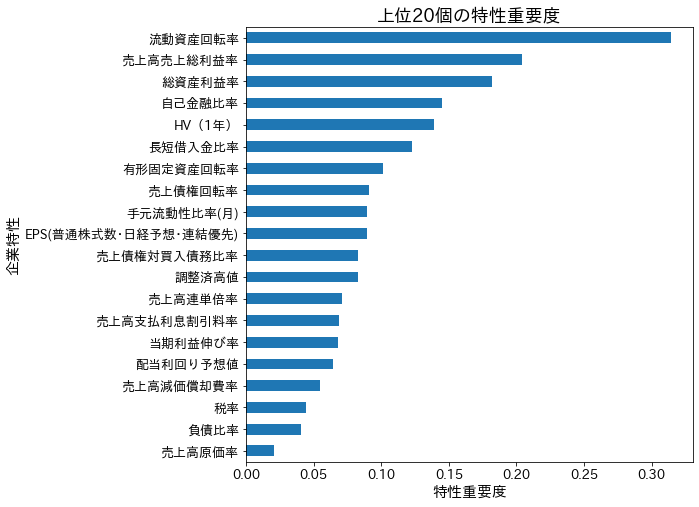

In [14]:
import japanize_matplotlib
import matplotlib.pyplot as plt
totalR_frame_3_2 = totalR_frame_2_2.sort_values('特性重要度' , ascending=False) #降順に並べ替え
totalR_frame_4_2 = totalR_frame_3_2.iloc[:20,0] #上位20個の特性を抜き出し
totalR_frame_5_2 = totalR_frame_4_2.sort_values(ascending=True)
plt.figure(figsize=(8,8))
totalR_frame_5_2.plot.barh()
plt.title("上位20個の特性重要度", fontsize=18)
plt.xlabel('特性重要度', fontsize=15)
plt.ylabel('企業特性', fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

In [15]:
print('全体で上位20個の企業特性が占める割合は' ,totalR_frame_4_2.sum()*100, '%である。')

全体で上位20個の企業特性が占める割合は 207.69204951518753 %である。


## 7.2 下位20個の特性重要度

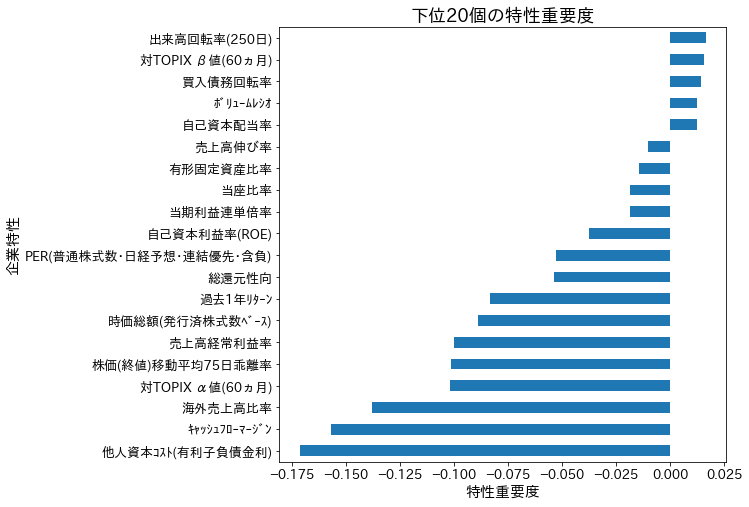

In [16]:
totalR_frame_3_2_1 = totalR_frame_2_2.sort_values('特性重要度' , ascending=True) #昇順に並べ替え
totalR_frame_4_2_1 = totalR_frame_3_2_1.iloc[:20,0] #下位20個の特性を抜き出し
totalR_frame_5_2_1 = totalR_frame_4_2_1.sort_values(ascending=True)
plt.figure(figsize=(8,8))
totalR_frame_5_2_1.plot.barh()
plt.title("下位20個の特性重要度", fontsize=18)
plt.xlabel('特性重要度', fontsize=15)
plt.ylabel('企業特性', fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

# 8. 特性重要度の可視化([0,1]に正規化した場合)
特性重要度はその合計が1となるように正規化している。

## 8.1 上位20個の特性重要度

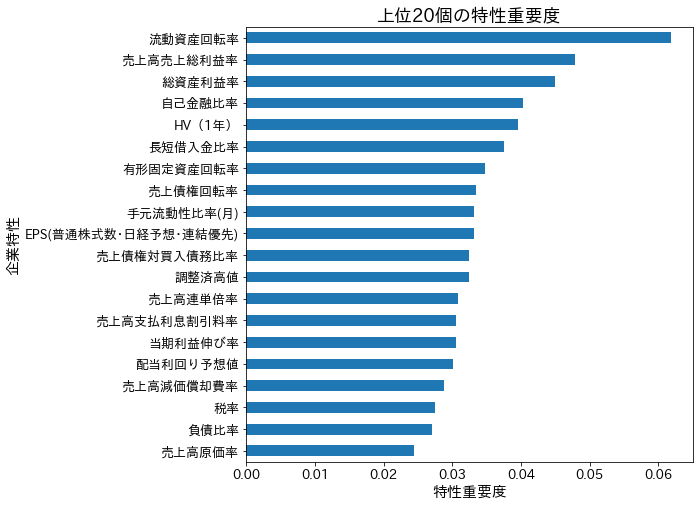

In [17]:
a = ((totalR_frame_2_2-totalR_frame_2_2.min())/(totalR_frame_2_2.max()-totalR_frame_2_2.min())) #[0,1]にする
a_2 = a/a.sum() #合計値が1となるように処理
a_3 = a_2.sort_values('特性重要度' , ascending=False) #降順に並べ替え
a_4 = a_3.iloc[:20,0] #上位20個の特性を抜き出し
a_5 = a_4.sort_values(ascending=True)
plt.figure(figsize=(8,8))
a_5.plot.barh()
plt.title("上位20個の特性重要度", fontsize=18)
plt.xlabel('特性重要度', fontsize=15)
plt.ylabel('企業特性', fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

In [18]:
print('全体で上位20個の企業特性が占める割合は' ,a_5.sum()*100, '%である。')

全体で上位20個の企業特性が占める割合は 70.07668442984468 %である。


## 8.2 下位20個の特性重要度

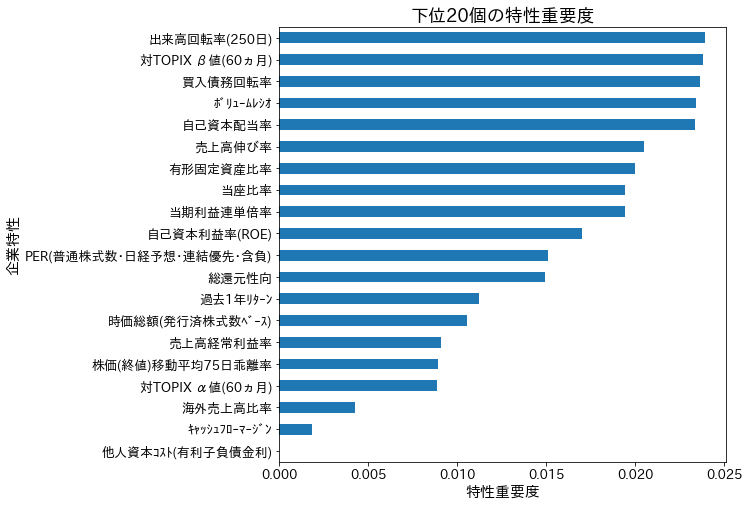

In [19]:
a_3_1 = a_2.sort_values('特性重要度' , ascending=True) #降順に並べ替え
a_4_1 = a_3_1.iloc[:20,0] #上位20個の特性を抜き出し
a_5_1 = a_4_1.sort_values(ascending=True)
plt.figure(figsize=(8,8))
a_5_1.plot.barh()
plt.title("下位20個の特性重要度", fontsize=18)
plt.xlabel('特性重要度', fontsize=15)
plt.ylabel('企業特性', fontsize=15)
plt.tick_params(labelsize=13)
plt.show()